- Can we predict **water temperature** (T_degC)
- There are many given features such as salinity (Salnty)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
# https://www.kaggle.com/datasets/sohier/calcofi
df = pd.read_csv("bottle.csv")

/home/moustafa/system-installs1/anaconda3/envs/pyt/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (47,73) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


- Our first goal is building simpe baseline (benchmark) and either improve it or introduce other complex ideas
  - The main purpose of a baseline model is to provide a point of comparison
- Make your goal to finish it with simple/effective choices

In [3]:
pd.options.display.max_columns = None  # show ALL columns (or rows) if you want in df.head to avoid ...
pd.options.display.max_rows = 500

df.shape

(864863, 74)

- Do fast check for what are your columns
- How many NA elements per column
- Drop columns with excessive NA elements
- What are column data types? date, string, intger, float, etc
- Either drop rows with NA elements or do simple replacements

In [4]:
df.isna().sum()

Cst_Cnt                     0
Btl_Cnt                     0
Sta_ID                      0
Depth_ID                    0
Depthm                      0
T_degC                  10963
Salnty                  47354
O2ml_L                 168662
STheta                  52689
O2Sat                  203589
Oxy_µmol/Kg            203595
BtlNum                 746196
RecInd                      0
T_prec                  10963
T_qual                 841736
S_prec                  47354
S_qual                 789949
P_qual                 191108
O_qual                 680187
SThtaq                 799040
O2Satq                 647066
ChlorA                 639591
Chlqua                 225697
Phaeop                 639592
Phaqua                 225693
PO4uM                  451546
PO4q                   413077
SiO3uM                 510772
SiO3qu                 353997
NO2uM                  527287
NO2q                   335389
NO3uM                  527460
NO3q                   334930
NH3uM     

- Let's find columns with little missing elements (maybe 7%?)
- Explore the data types of the remaining columns

In [5]:
columns = [col for col in df.columns if df[col].isna().sum() <= 0.07 * df.shape[0]]
columns

['Cst_Cnt',
 'Btl_Cnt',
 'Sta_ID',
 'Depth_ID',
 'Depthm',
 'T_degC',
 'Salnty',
 'STheta',
 'RecInd',
 'T_prec',
 'S_prec',
 'NH3q',
 'C14A1q',
 'C14A2q',
 'DarkAq',
 'MeanAq',
 'R_Depth',
 'R_TEMP',
 'R_POTEMP',
 'R_SALINITY',
 'R_SIGMA',
 'R_SVA',
 'R_DYNHT',
 'R_PRES']

In [6]:
df = df[columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864863 entries, 0 to 864862
Data columns (total 24 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Cst_Cnt     864863 non-null  int64  
 1   Btl_Cnt     864863 non-null  int64  
 2   Sta_ID      864863 non-null  object 
 3   Depth_ID    864863 non-null  object 
 4   Depthm      864863 non-null  int64  
 5   T_degC      853900 non-null  float64
 6   Salnty      817509 non-null  float64
 7   STheta      812174 non-null  float64
 8   RecInd      864863 non-null  int64  
 9   T_prec      853900 non-null  float64
 10  S_prec      817509 non-null  float64
 11  NH3q        808299 non-null  float64
 12  C14A1q      848605 non-null  float64
 13  C14A2q      848623 non-null  float64
 14  DarkAq      840440 non-null  float64
 15  MeanAq      840439 non-null  float64
 16  R_Depth     864863 non-null  float64
 17  R_TEMP      853900 non-null  float64
 18  R_POTEMP    818816 non-null  float64
 19  R_

- We have 5 integer based columns and 2 object columns. Remaining is float
- Let's see what is there in these object columns

In [7]:
df[['Sta_ID', 'Depth_ID']].head()

Sta_ID                                Depth_ID
0  054.0 056.0  19-4903CR-HY-060-0930-05400560-0000A-3
1  054.0 056.0  19-4903CR-HY-060-0930-05400560-0008A-3
2  054.0 056.0  19-4903CR-HY-060-0930-05400560-0010A-7
3  054.0 056.0  19-4903CR-HY-060-0930-05400560-0019A-3
4  054.0 056.0  19-4903CR-HY-060-0930-05400560-0020A-7

- Seems maynot be so informative string columns
- We can remove for now
- But maybe we return them later and encode them (e.g. Hash Encoding)

In [8]:
columns.remove('Sta_ID')
columns.remove('Depth_ID')

- Time to deal with missing elements
- Given the volume of data, a SIMPLE solution is just to remove

In [9]:
df = df[columns]
df.dropna(axis = 0, inplace = True)
df.shape

(733418, 22)

- Next step is encoding this data, which is mix of int and float
- First explore their statistics, especially std
- For Large values or large std, we may apply log function
- Let's first explore the integer columns

In [10]:
df_flot = df.select_dtypes(include=['float64']) # or np.floating
df_int = df.select_dtypes(include=['int64'])  # or include=[np.integer]
df_int.describe()

Cst_Cnt        Btl_Cnt         Depthm         RecInd  \
count  733418.000000  733418.000000  733418.000000  733418.000000   
mean    16421.194724  414217.185100     228.062580       4.723822   
std      9482.694845  230069.296792     309.103372       1.865705   
min         1.000000       1.000000       0.000000       3.000000   
25%      8492.000000  222666.250000      50.000000       3.000000   
50%     15633.000000  412554.500000     125.000000       3.000000   
75%     24876.000000  608509.750000     300.000000       7.000000   
max     34404.000000  864861.000000    5351.000000       7.000000   

              R_PRES  
count  733418.000000  
mean      229.580553  
std       312.359267  
min         0.000000  
25%        50.000000  
50%       126.000000  
75%       302.000000  
max      5458.000000

- All the variables except RecInd has large values or std. Let's log them
- RecInd seems normal categorical info. No metadata from the dataset, although seems some index
- Let's see a histogram of RecInd

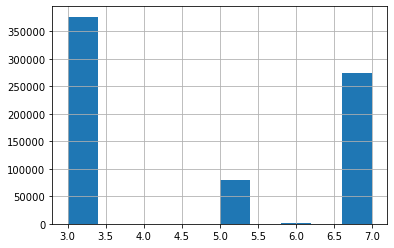

In [11]:
df_int['RecInd'].hist()
plt.show()

In [12]:
# Let's get the frequencies.
freq_series = df_int['RecInd'].value_counts()
freq_series

3    376861
7    275121
5     80506
6       928
4         2
Name: RecInd, dtype: int64

- Seems this index range up to 7. Let's assume no more than that 
- tip: in inference be careful if a value > 7
- Let's pretend we are sure it is [0-7] range. We can just convert the whole column for now
- Let's convert to one hot encoding (use get_dummies)
- Let's convert others using log1p function
- Convert on original columns

In [13]:
# Note, it will map the available 4 classes to {0, 1, 2, 3}
df = pd.get_dummies(df, columns=['RecInd'])

In [14]:
lg_int = ['Btl_Cnt', 'Cst_Cnt', 'Depthm', 'R_PRES']

for c in lg_int:
    df[c] = np.log1p(df[c])

- Let's explore float variables

In [15]:
df_flot.describe()

T_degC         Salnty         STheta         T_prec  \
count  733418.000000  733418.000000  733418.000000  733418.000000   
mean       10.764656      33.861743      25.848316       2.018854   
std         4.242786       0.460998       1.180908       0.154670   
min         1.440000      28.431000      20.934000       1.000000   
25%         7.670000      33.510000      25.004000       2.000000   
50%         9.980000      33.900000      26.043000       2.000000   
75%        13.780000      34.210000      26.661000       2.000000   
max        31.140000      37.034000     250.784000       3.000000   

              S_prec           NH3q         C14A1q         C14A2q  \
count  733418.000000  733418.000000  733418.000000  733418.000000   
mean        2.694038       8.944438       8.999992       8.999992   
std         0.460814       0.524139       0.002860       0.002860   
min         2.000000       4.000000       8.000000       8.000000   
25%         2.000000       9.000000       9.000000       9.000000   
50%         3.000000       9.000000       9.000000       9.000000   
75%         3.000000       9.000000       9.000000       9.000000   
max         3.000000       9.000000       9.000000       9.000000   

              DarkAq         MeanAq        R_Depth         R_TEMP  \
count  733418.000000  733418.000000  733418.000000  733418.000000   
mean        8.999992       8.999992     228.063188      10.764664   
std         0.002860       0.002860     309.103071       4.242788   
min         8.000000       8.000000       0.000000       1.440000   
25%         9.000000       9.000000      50.000000       7.670000   
50%         9.000000       9.000000     125.000000       9.980000   
75%         9.000000       9.000000     300.000000      13.780000   
max         9.000000       9.000000    5351.000000      31.140000   

            R_POTEMP     R_SALINITY        R_SIGMA          R_SVA  \
count  733418.000000  733418.000000  733418.000000  733418.000000   
mean       10.742996      33.861723      25.843458     217.910797   
std         4.259768       0.461000       1.133141      93.118892   
min         0.000000      28.431000      20.934000       0.400000   
25%         7.640000      33.510000      25.000000     142.200000   
50%         9.970000      33.900000      26.040000     198.300000   
75%        13.770000      34.210000      26.660000     295.700000   
max        31.140000      37.034000     250.784000     683.400000   

             R_DYNHT  
count  733418.000000  
mean        0.447131  
std         0.388606  
min         0.000000  
25%         0.150000  
50%         0.360000  
75%         0.650000  
max         3.880000

- Seems all of them are fine
- Except R_Depth has std 309
- We may leave it for scaling or try log over it first

In [16]:
df['R_Depth'] = np.log1p(df['R_Depth'])

- Next step is to split the data and scale it

In [17]:
# Extract the target and remove from columns 
# Observe columns variable is old now as we updated df
y = df[['T_degC']]
df.drop(columns=['T_degC'], inplace=True)
X = df
X_train, X_val, t_train, t_val = train_test_split(X, y, test_size=0.2, random_state=17)

In [18]:
X_train.shape, t_train.shape, X_val.shape, t_val.shape

((586734, 25), (586734, 1), (146684, 25), (146684, 1))

In [19]:
def transform_train_val(X_train, X_val):
    processor = MinMaxScaler()
    X_train = processor.fit_transform(X_train)
    X_val = processor.transform(X_val)
    return X_train, X_val

In [20]:
X_train, X_val = transform_train_val(X_train, X_val)

In [21]:
model = LinearRegression().fit(X_train, t_train)

In [22]:
y_pred_train = model.predict(X_train)
r2_score(t_train, y_pred_train)

0.9999999929474099

In [23]:
y_pred_val = model.predict(X_val)
r2_score(t_val, y_pred_val)

0.9999999928466711

- A bit suspecision but anyway :D
- Your next steps
- Do your EDA and explore/visualize the features
- Explore more encoding approaches if needed
- Try to select features
- Try to automatically add features
- Try to invenet features based on domain understanding
- Try more models!